# Predict Tomorrow's Market Gas Prices Today 

![price.png](price.png)

# Introduction

### Background

* On April 25, 2012, the candidate for president of Mexico (Enrique Peña Nieto) made a commitment to carry out an energy reform to reduce energy rates.

#### Oil

* Basic petrochemicals are eliminated from article 28 of the Constitution as a strategic area that does not constitute a monopoly, with this it allows individuals to participate directly under regulated schemes in the value chain after extraction, including transportation, both of crude oil , natural gas and its liquids, such as petrochemicals and refined products.

In [1]:
# libraries 

import pandas as pd   # pandas
import numpy as np    # numpy
import mysql.connector # mysql
from sqlalchemy import create_engine # mysql engine
import calendar

# Plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
# ======================================================================================================================
# ======================================================================================================================
# Mysql key

usr = "*******"
pwd = "*******"
db = "*******"

# create the engine for the MySQL object

engine = create_engine("mysql+mysqlconnector://" + usr +":" + pwd + "@localhost/" + db)

# ======================================================================================================================
# ======================================================================================================================
# Load data

columns_masterbrand = ["no_estacion", "no_pemex", "razon_social", "sub_brand",
                       "cp", "address", "longitude", "latitude", "edo_cre", "regular_subsidie",
                       "premium_subsidie", "val"]

master_brand = pd.read_sql('masterbrandmirror', con = engine)
master_brand.drop(columns = columns_masterbrand, inplace = True)
master_brand["terminal_cre"] = master_brand["terminal_cre"].str.replace('Á', 'A', regex = False).str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U').str.replace('Ñ', 'N')

# ======================================================================================================================
# ======================================================================================================================
# Read the rack price dataset

path_rackprice = r"C:\Users\migue\Documents\BP\datasets\cogs\RackPrice.xlsx"
pd_rackprice00 = pd.read_excel(path_rackprice, sheet_name = "Sheet1")
pd_rackprice00 = pd_rackprice00[["Terminal", "Fecha", "Precio TAR Regular (lt)", "Precio TAR Premium (lt)", "Precio TAR Diesel (lt)"]]

# ======================================================================
# ======================================================================
# Define the rack price dataset

df_rack_price = pd.DataFrame() 

df_rack_regular = pd_rackprice00[["Terminal", "Fecha", "Precio TAR Regular (lt)"]]
df_rack_regular = df_rack_regular.rename(columns = {"Precio TAR Regular (lt)" : "COG"})
df_rack_regular["producto"] = "regular"

df_rack_premium = pd_rackprice00[["Terminal", "Fecha", "Precio TAR Premium (lt)"]]
df_rack_premium = df_rack_premium.rename(columns = {"Precio TAR Premium (lt)" : "COG"})
df_rack_premium["producto"] = "premium"

df_rack_diesel = pd_rackprice00[["Terminal", "Fecha", "Precio TAR Diesel (lt)"]]
df_rack_diesel = df_rack_diesel.rename(columns = {"Precio TAR Diesel (lt)" : "COG"})
df_rack_diesel["producto"] = "diesel"

df_rack_price = df_rack_price.append(df_rack_regular, sort = False)
df_rack_price = df_rack_price.append(df_rack_premium, sort = False)
df_rack_price = df_rack_price.append(df_rack_diesel, sort = False)

df_rack_price["concat"] = df_rack_price["producto"] + df_rack_price["Terminal"] + df_rack_price["Fecha"].astype('str')
del pd_rackprice00

### Cost of Goods Sold

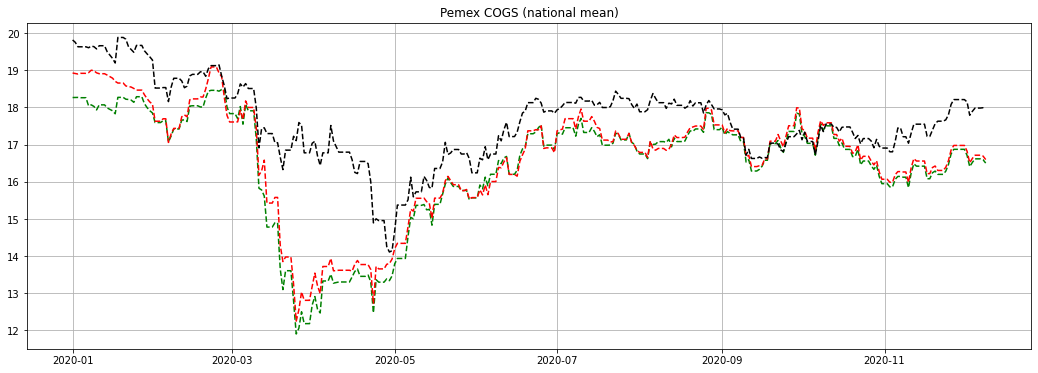

In [3]:
fig = plt.figure(figsize = (18, 6))
df_rack_price.producto.unique()

for product in df_rack_price.producto.unique():
    buffer = df_rack_price[(df_rack_price.producto == product) & (df_rack_price.Fecha >= '2020-01-01')].groupby(by = ["Fecha"], 
                                                                                                                as_index = False).mean()
    if product == "regular":
        style = "g--"                
    elif product == "premium":
        style = "r--"        
    elif product == "diesel":
        style = "k--"        
        
    plt.plot(buffer.Fecha, buffer.COG, style)

plt.title("Pemex COGS (national mean)")
plt.grid(True)
plt.show()

* From the above we can see that during the month of March there was a great variation in the prices of hydrocarbons as a consequence of the fall in the price of oil at international level, this translated into lower sale prices to the public from this date . Additionally, we see how the premium product even for certain periods of time becomes cheaper than the regular product.

## International context

### Oil price - WTI (west texas intermediate)

* During the first part of 2020, the crude oil prices were above 50 dollars but during the second week of March this fell below 25 dollars as a result of the COVID pandemic, the consequence of the above was that Gasoline prices in Mexico fell sharply during the second part of March, starting from the second Friday in March.


* During the last week of April, the international prices of WTI (west texas intermediate) fell to levels never seen before, even reaching negative prices, an effect that could only be seen for one day.


* The negative price effect was caused by the trading of future contracts that were about to expire during the last week of April, due to the fact that the crude stocks were full due to the low demand caused by the pandemic, this caused that nobody had enough space to receive more crude. On the other hand, although during the same period of time the Brent reference was impacted with a considerable drop in the reference price, it never reached negative prices.


* Note - the future contract delivery point for WTI is Cushing (Oklahoma) as opposed to Brent which is delivered in the North Sea.

![oil.png](oil.png)

### Market Analysis

* The following exercise is intended to predict the future price of gasoline.


* The data are based on the prices reported day by day of some stations within the Toluca valley, taking into account towns such as Toluca, Zinacantepec, Metepec, Lerma and San Mateo Atenco.

In [4]:
site_name = ["sites"]

df_micromkt = pd.read_excel(r"C:\Users\migue\Documents\BP\Micromarkets.xlsx", sheet_name = "sites")
micromkt = df_micromkt[site_name].rename(columns = {'sites' : 'place_id'})

array0 = []

for a in micromkt.place_id:    
    array0.append(str(a))
    
placeid_array = str(array0).replace("[","").replace("]","").replace("'","")

In [5]:
pd_buffer = pd.DataFrame()
query = "select place_id, regular, premium, diesel, update_data_date from pricing_bp.cre_prices where place_id in (" + placeid_array +") and update_data_date >= '2020-01-01';"

# Prices
cre_prices = pd.read_sql(query, con = engine)

buffer_regular = cre_prices.drop(columns = ["premium", "diesel"]).rename(columns = {"regular" : "price"})
buffer_regular["product"] = "regular"        
    
buffer_premium = cre_prices.drop(columns = ["regular", "diesel"]).rename(columns = {"premium" : "price"})
buffer_premium["product"] = "premium"        
    
buffer_diesel = cre_prices.drop(columns = ["regular", "premium"]).rename(columns = {"diesel" : "price"})
buffer_diesel["product"] = "diesel"        
    
pd_buffer = pd_buffer.append(buffer_regular, sort = False)
pd_buffer = pd_buffer.append(buffer_premium, sort = False)
pd_buffer = pd_buffer.append(buffer_diesel, sort = False)

df = pd_buffer.merge(master_brand, on = "place_id").rename(columns = {"update_data_date" : "date"})
df["concat"] = df["product"] + df["terminal_cre"] + df["date"].astype('str')
df["date"] = df.date.astype('datetime64')
df = df.merge(df_rack_price, how = "left", on = "concat").drop(columns = ["concat", "producto", "Fecha", "Terminal"])
df = df[df.price > 0]
df["week_day"] = df.date.dt.weekday
df["month"] = df.date.dt.month

### Market participants

* As we can see in the next list, there are many differents brands labeled by letters.

In [6]:
print("Brands: ")

for brand in df.brand.unique():
    print("   * " + brand)

Brands: 
   * b
   * i
   * h
   * g
   * f
   * a
   * e
   * an


### Market prices

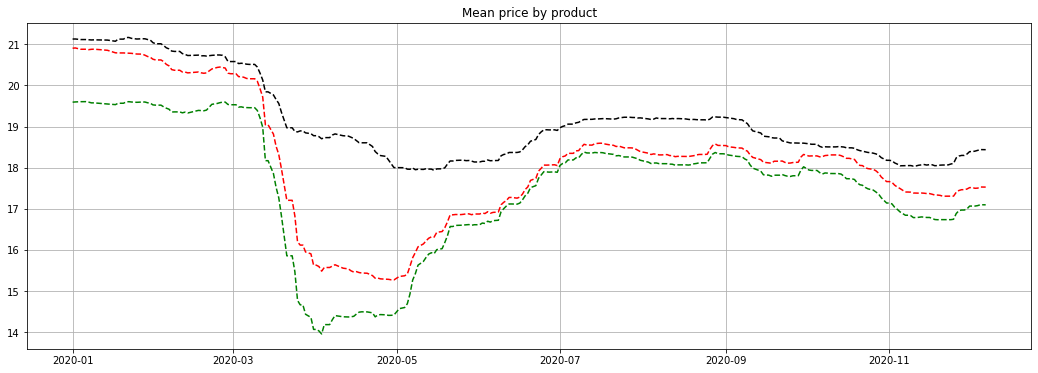

In [7]:
fig = plt.figure(figsize = (18, 6))
df["product"].unique()

for product in df["product"].unique():
    buffer = df[df["product"] == product].groupby(by = ["date"], as_index = False).mean()
    
    if product == "regular":
        style = "g--"                
    elif product == "premium":
        style = "r--"        
    elif product == "diesel":
        style = "k--" 
        
    plt.plot(buffer.date, buffer.price, style)

plt.grid(True)
plt.title("Mean price by product")
plt.show()

* As we can see, the prices of gasoline had a quite pronounced fall, not so for Diesel, which maintained much more stable prices. We can even observe that during some periods of time the prices of regular and premium products were the same or almost the same.

In [8]:
# Info about the data set

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119100 entries, 0 to 130065
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   place_id      119100 non-null  int64         
 1   price         119100 non-null  float64       
 2   date          119100 non-null  datetime64[ns]
 3   product       119100 non-null  object        
 4   permiso       119100 non-null  object        
 5   name          119100 non-null  object        
 6   brand         119100 non-null  object        
 7   terminal_cre  119100 non-null  object        
 8   town          119100 non-null  object        
 9   state         119100 non-null  object        
 10  iva           119100 non-null  float64       
 11  COG           119100 non-null  float64       
 12  week_day      119100 non-null  int64         
 13  month         119100 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 

In [9]:
# Stats data for regular product

df[df["product"] == "regular"].describe()

,place_id,price,iva,COG,week_day,month
count,43368.000000,43368.000000,43368.00,43368.000000,43368.000000,43368.000000
mean,11331.805179,17.461408,0.16,16.370927,2.505649,6.393700
std,7692.069460,1.631501,0.00,1.542507,1.787798,3.229373
min,2629.000000,12.710000,0.16,11.842333,0.000000,1.000000
25%,5377.000000,16.550000,0.16,15.892520,1.000000,4.000000
50%,8795.000000,17.730000,0.16,16.891604,2.000000,6.000000
75%,14323.000000,18.590000,0.16,17.401935,4.000000,9.000000
max,27154.000000,21.490000,0.16,18.401832,6.000000,12.000000


In [10]:
# Stats data for premium product

df[df["product"] == "premium"].describe()

,place_id,price,iva,COG,week_day,month
count,43088.000000,43088.000000,43088.00,43088.000000,43088.000000,43088.000000
mean,11363.717207,18.040729,0.16,16.443233,2.505663,6.393938
std,7706.795599,1.641823,0.00,1.487876,1.787805,3.229321
min,2629.000000,13.710000,0.16,12.116709,0.000000,1.000000
25%,5377.000000,16.990000,0.16,15.824754,1.000000,4.000000
50%,8795.000000,17.990000,0.16,16.767045,2.000000,6.000000
75%,14323.000000,18.890000,0.16,17.371010,4.000000,9.000000
max,27154.000000,21.810000,0.16,18.926710,6.000000,12.000000


In [11]:
# Stats data for diesel product

df[df["product"] == "diesel"].describe()

,place_id,price,iva,COG,week_day,month
count,32644.000000,32644.000000,32644.00,32644.000000,32644.000000,32644.000000
mean,11673.698413,19.045093,0.16,17.535589,2.504472,6.373667
std,7781.529109,1.096449,0.00,1.053468,1.787165,3.230810
min,2629.000000,16.500000,0.16,14.059706,0.000000,1.000000
25%,5461.000000,18.250000,0.16,16.900627,1.000000,4.000000
50%,8957.000000,18.850000,0.16,17.585804,2.000000,6.000000
75%,20868.000000,19.430000,0.16,18.155828,4.000000,9.000000
max,26607.000000,21.980000,0.16,19.872106,6.000000,12.000000


In [12]:
# Verify if the dataset contain null data

df.isnull().sum()

place_id        0
price           0
date            0
product         0
permiso         0
name            0
brand           0
terminal_cre    0
town            0
state           0
iva             0
COG             0
week_day        0
month           0
dtype: int64

### Data distribution for each variable

array([[<AxesSubplot:title={'center':'place_id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'iva'}>,
        <AxesSubplot:title={'center':'COG'}>],
       [<AxesSubplot:title={'center':'week_day'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

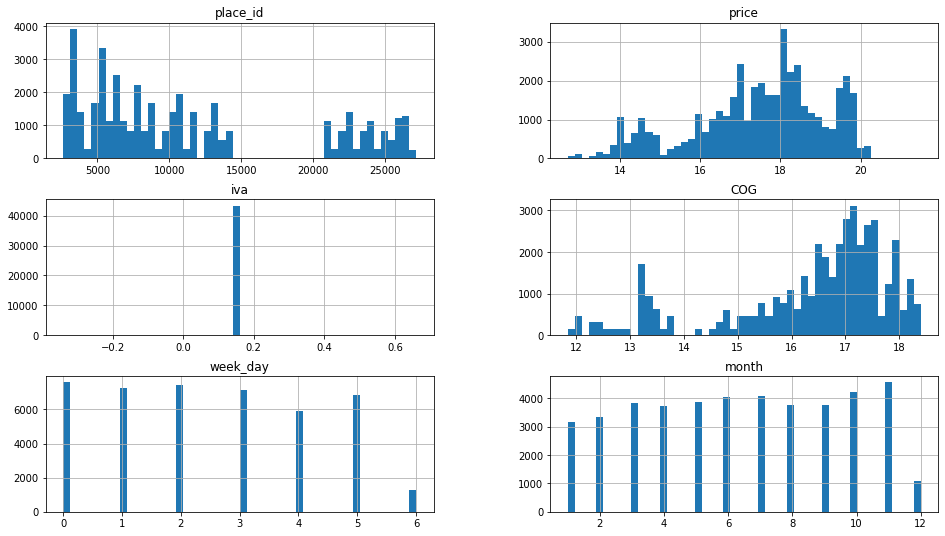

In [13]:
df[df["product"] == "regular"].hist(bins = 50, figsize = (16, 9))

array([[<AxesSubplot:title={'center':'place_id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'iva'}>,
        <AxesSubplot:title={'center':'COG'}>],
       [<AxesSubplot:title={'center':'week_day'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

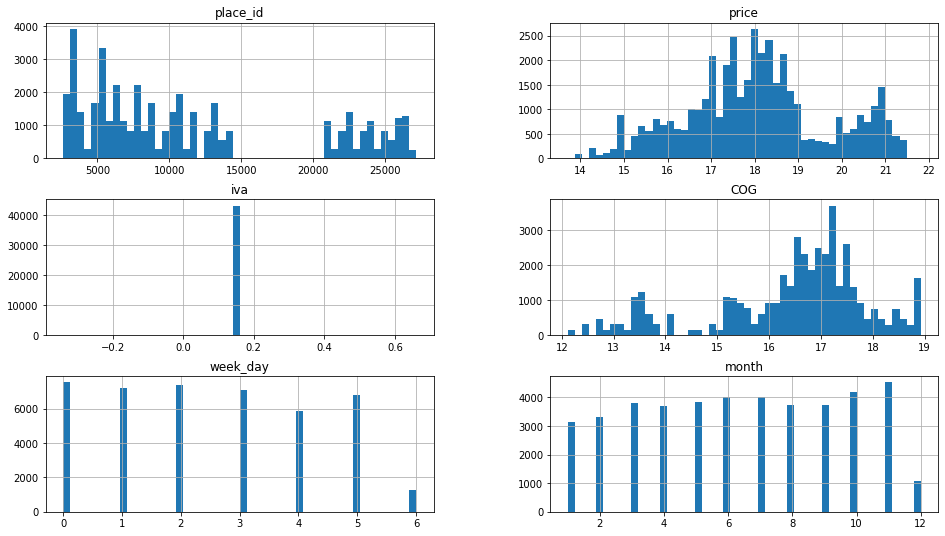

In [14]:
df[df["product"] == "premium"].hist(bins = 50, figsize = (16, 9))

array([[<AxesSubplot:title={'center':'place_id'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'iva'}>,
        <AxesSubplot:title={'center':'COG'}>],
       [<AxesSubplot:title={'center':'week_day'}>,
        <AxesSubplot:title={'center':'month'}>]], dtype=object)

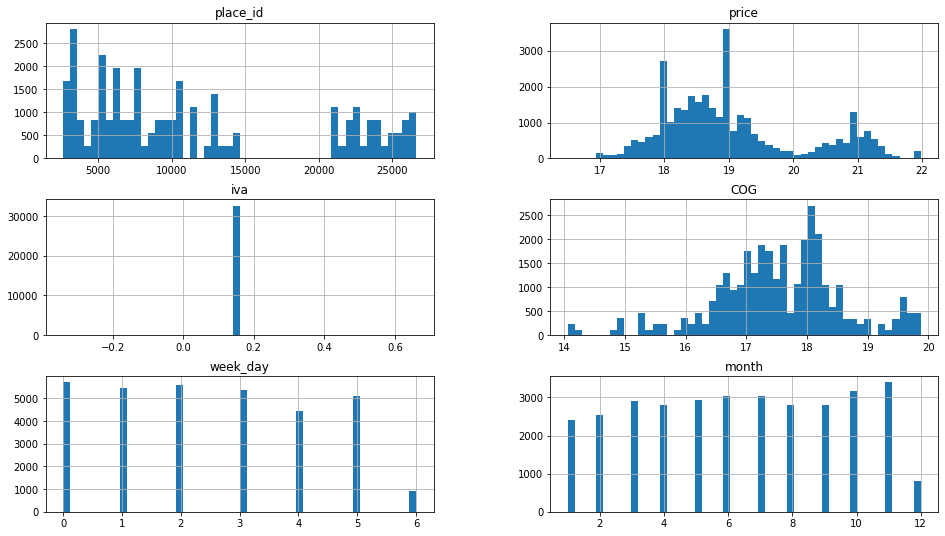

In [15]:
df[df["product"] == "diesel"].hist(bins = 50, figsize = (16, 9))

* From the above we can see that in products such as gasoline during 2020 there was greater volatility in prices, otherwise it was diesel which maintained a much more stable price. The cause of it may be that the average cost of the Diesel product was much more stable, not so for gasoline.

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='COG', ylabel='price'>,
        <AxesSubplot:xlabel='week_day', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='COG'>,
        <AxesSubplot:xlabel='COG', ylabel='COG'>,
        <AxesSubplot:xlabel='week_day', ylabel='COG'>],
       [<AxesSubplot:xlabel='price', ylabel='week_day'>,
        <AxesSubplot:xlabel='COG', ylabel='week_day'>,
        <AxesSubplot:xlabel='week_day', ylabel='week_day'>]], dtype=object)

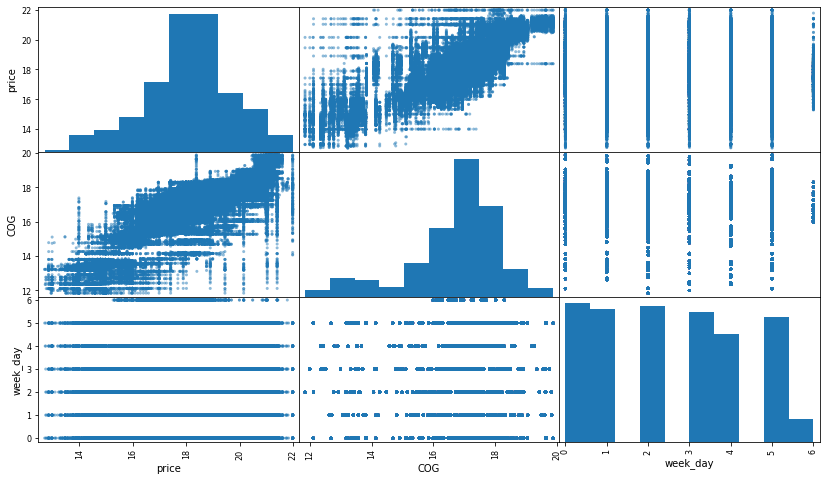

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["price", "COG", "week_day"]
scatter_matrix(df[attributes], figsize = (14, 8))

* Apparently the most important variable for setting prices is cost.


* There are service stations that can take as a starting point a cost strategy in which if the cost rises, the prices increase and vice versa.

### Price vs COGS (mean)

* The next charts present the price behavior vs cog behavior by brand

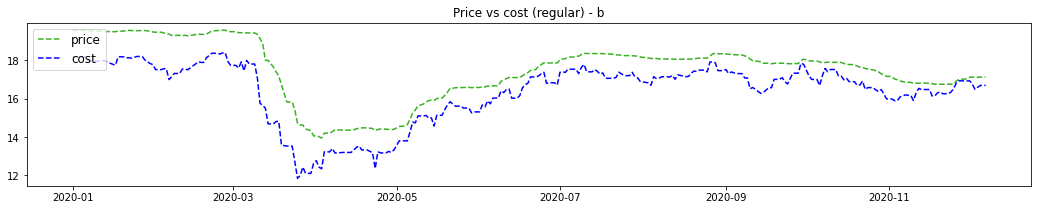

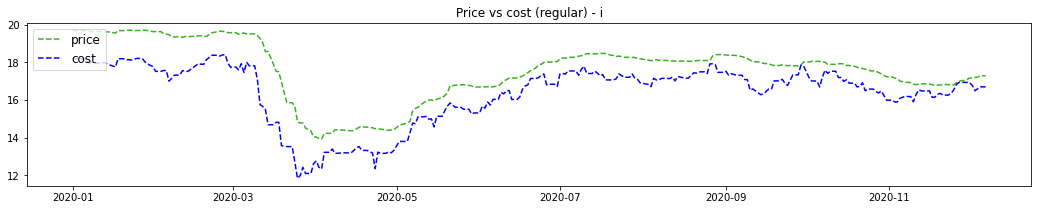

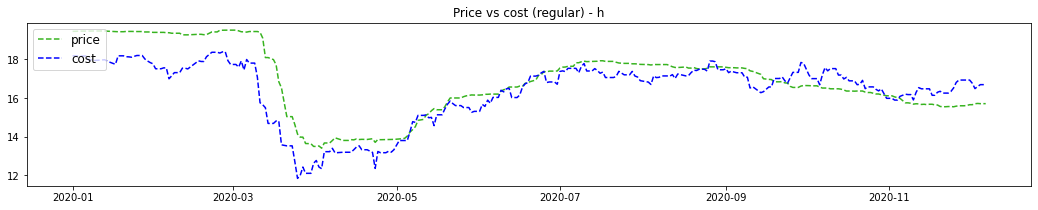

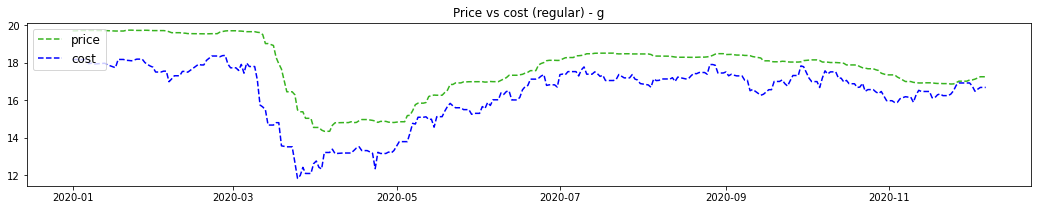

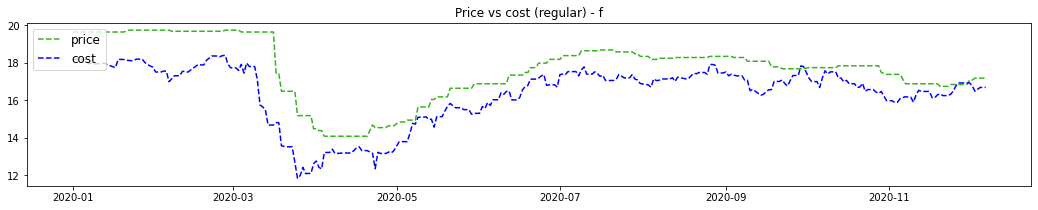

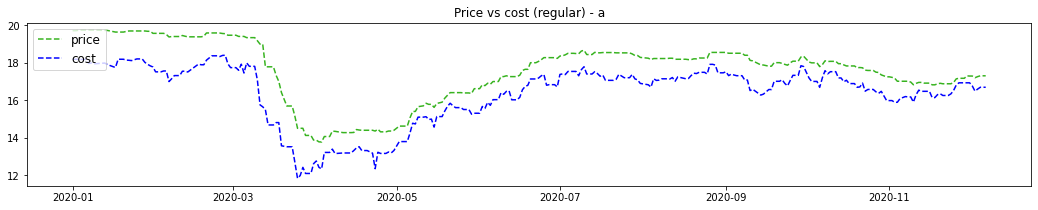

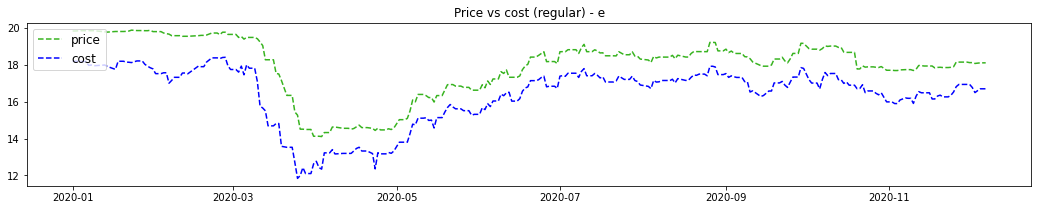

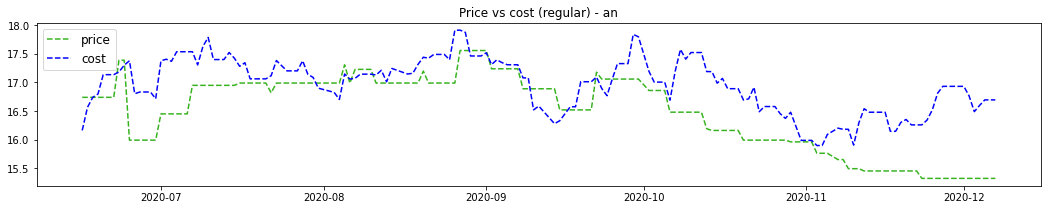

In [17]:
for a in df.brand.unique():
    
    fig = plt.figure(figsize = (18, 3))
    buffer = df[(df.brand == a) & (df["product"] == "regular")].groupby( by = ["date"], as_index = False).mean()
    plt.plot(buffer.date, buffer.price, "g--", label = "price", color = "#37B31F")
    plt.plot(buffer.date, buffer.COG, "b--", label = "cost")
    plt.legend(loc = "upper left", fontsize = 12)
    plt.title("Price vs cost (regular) - " + str(a))
    plt.show()

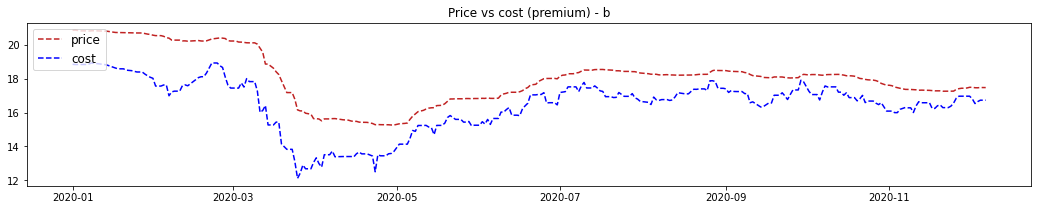

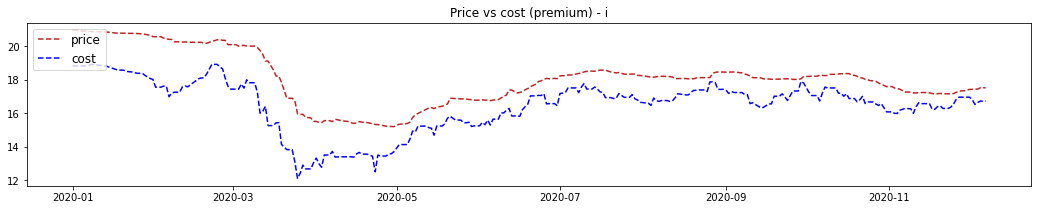

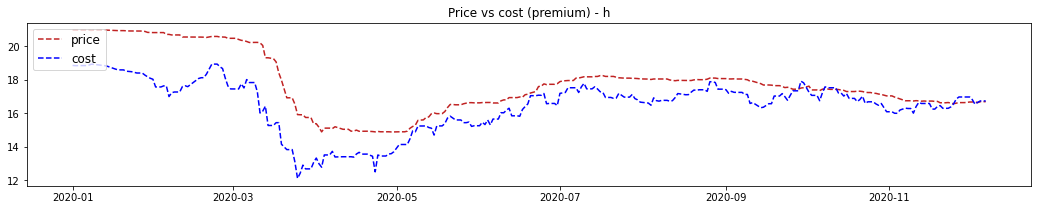

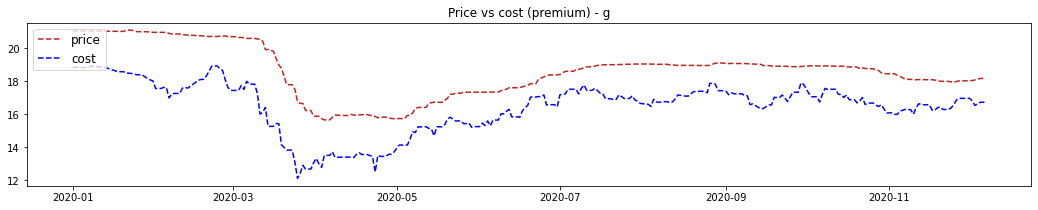

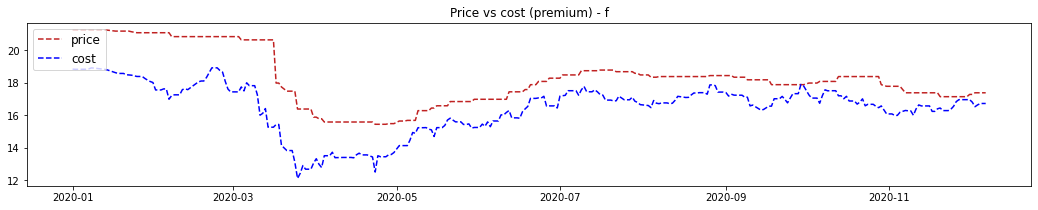

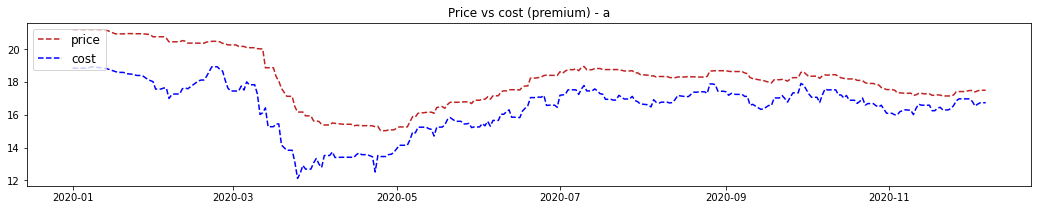

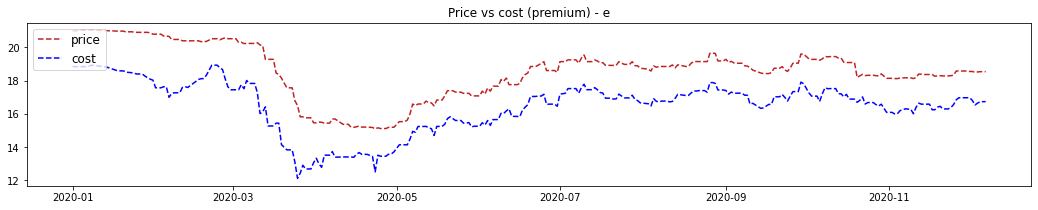

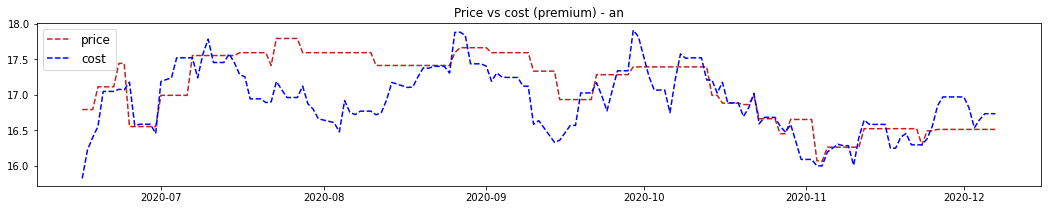

In [18]:
for a in df.brand.unique():
    
    fig = plt.figure(figsize = (18, 3))
    buffer = df[(df.brand == a) & (df["product"] == "premium")].groupby( by = ["date"], as_index = False).mean()
    plt.plot(buffer.date, buffer.price, "r--", label = "price", color = "#C02222")
    plt.plot(buffer.date, buffer.COG, "b--", label = "cost")
    plt.legend(loc = "upper left", fontsize = 12)
    plt.title("Price vs cost (premium) - " + str(a))
    plt.show()

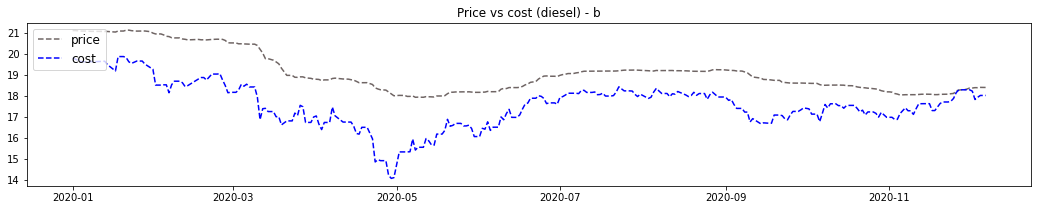

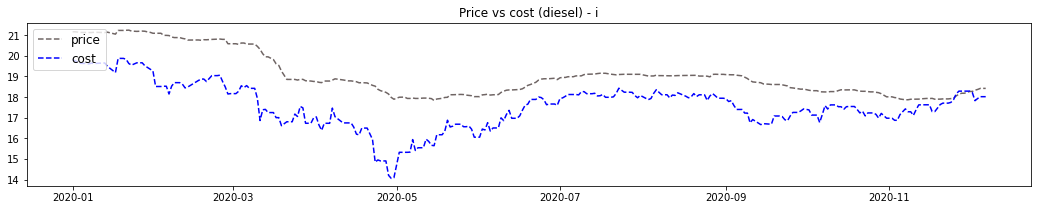

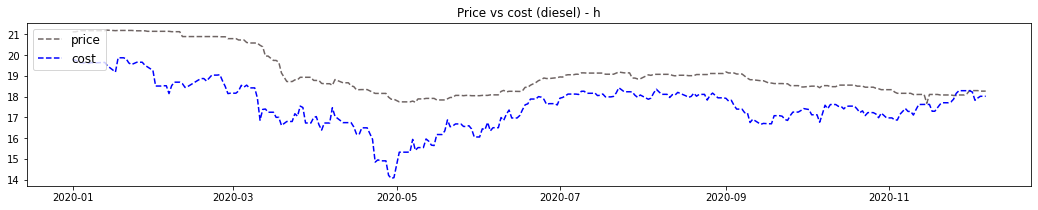

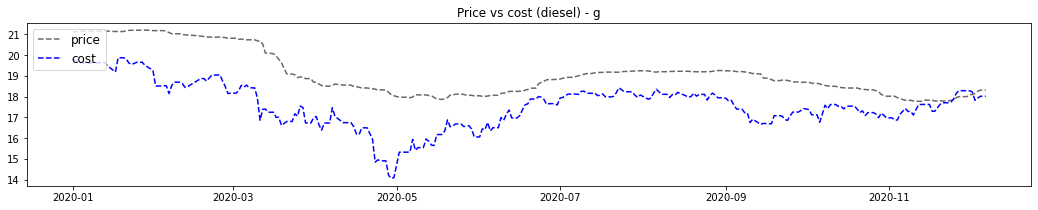

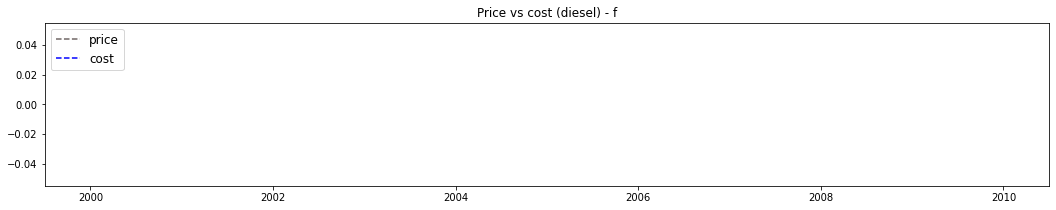

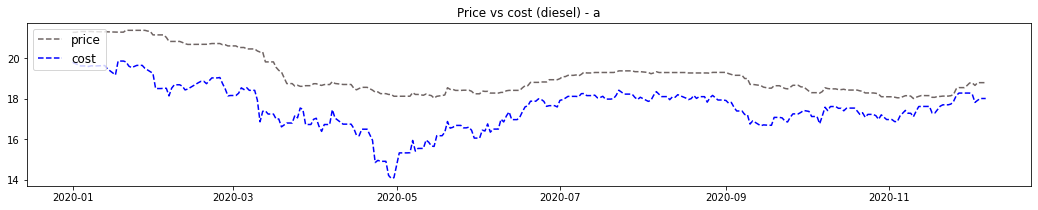

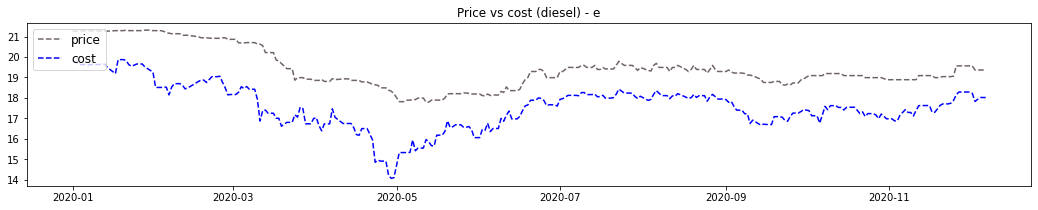

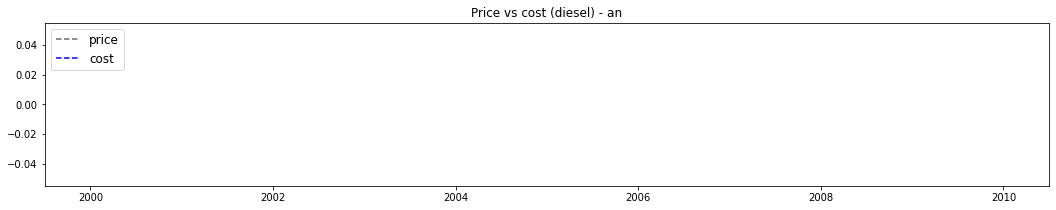

In [19]:
for a in df.brand.unique():
    
    fig = plt.figure(figsize = (18, 3))
    buffer = df[(df.brand == a) & (df["product"] == "diesel")].groupby( by = ["date"], as_index = False).mean()
    plt.plot(buffer.date, buffer.price, "--", label = "price", color = "#6F6564")
    plt.plot(buffer.date, buffer.COG, "b--", label = "cost")
    plt.legend(loc = "upper left", fontsize = 12)
    plt.title("Price vs cost (diesel) - " + str(a))
    plt.show()

* There are brands that take as a starting point lowering the price too much
  which can clearly indicate a volume strategy, this strategy is
  even more visible for the "an" brand; on the other hand brands like "e" which
  are willing to sacrifice volume in order to generate greater monetary benefits by each unit sold


* The aforementioned pattern is replicated for gasoline although there may be strategies
  price by product


* Note: brands "f" and "an" do not show a diesel graph because they do not offer the product

### Mean price by brand

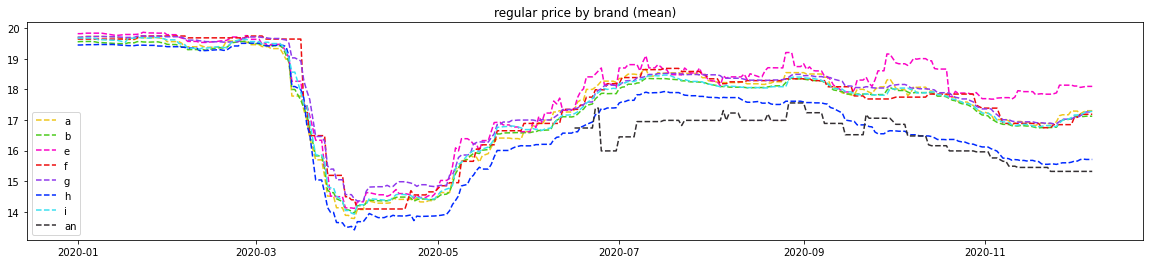

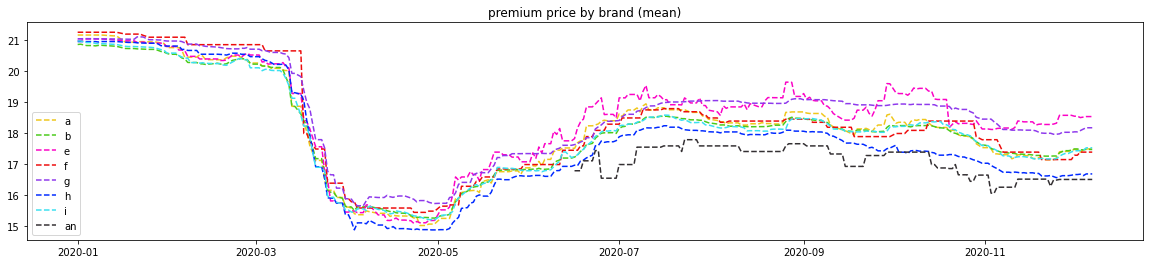

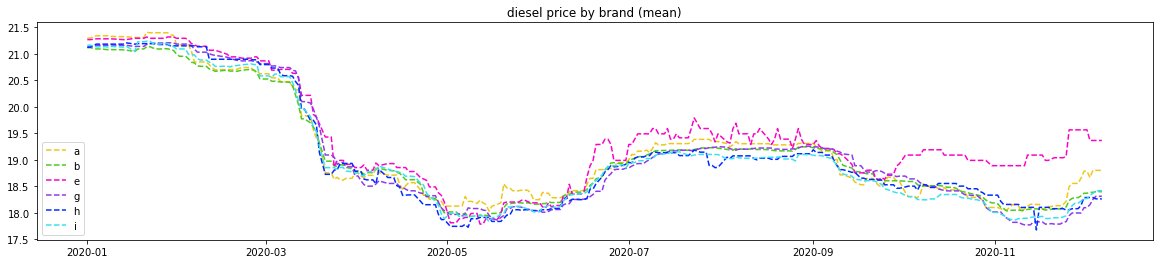

In [20]:
def style_plot_brand(brand):
    
    if brand == "b":
        style = "--"
        label = brand
        color = "#4BCB1A"
        
    elif brand == "i":
        style = "--"
        label = brand
        color = "#3AE0F0"
        
    elif brand == "h":
        style = "--"
        label = brand
        color = "#002AFF"
        
    elif brand == "g":
        style = "--"
        label = brand
        color = "#8E39EC"
        
    elif brand == "f":
        style = "--"
        label = brand
        color = "#ED0C0C"
        
    elif brand == "a":
        style = "--"
        label = brand
        color = "#EFC71B"
        
    elif brand == "e":
        style = "--"
        label = brand
        color = "#FB03C6"
        
    else:
        style = "--"
        label = brand
        color = "#332F32"
    
    return style, brand, color

for a in df["product"].unique():
    
    fig = plt.figure(figsize = (20, 4))
    buffer = df[(df["product"] == a)].groupby( by = ["date", "brand"], as_index = False).mean()    
    
    for b in buffer.brand.unique():
        buffer_ = buffer[buffer.brand == b]
        
        style, brand, color = style_plot_brand(b)
        
        plt.plot(buffer_.date, buffer_.price, style, label = brand, color = color)
        plt.legend(loc = "lower left", fontsize = 10)
        plt.title(str(a) + " price by brand (mean)")
    plt.show()    

* Most prices maintain an upward trend from May with stabilicidation during the months of June to August (approximately) to end with some drops towards November, this is due to the international behavior of crude oil and the market itself.

## Linear models

* In the next section we will evaluate different prediction models in order to determine which is the one that best suits to our purpose, predict the future price market for the regular product.

### Linear regression

![lin_reg.jpeg](lin_reg.jpeg)

In [21]:
# Prepare the data for the regression

df_lin_reg = df[df["product"] == "regular"].groupby(by = ["date"], as_index = False).mean()
df_lin_reg["index"] = df_lin_reg.index
df_lin_reg.head(3)

,date,place_id,price,iva,COG,week_day,month,index
0,2020-01-01,10745.395973,19.594765,0.16,18.185515,2.0,1.0,0
1,2020-01-02,10745.395973,19.599799,0.16,18.188612,3.0,1.0,1
2,2020-01-04,10843.893333,19.605667,0.16,18.177128,5.0,1.0,2


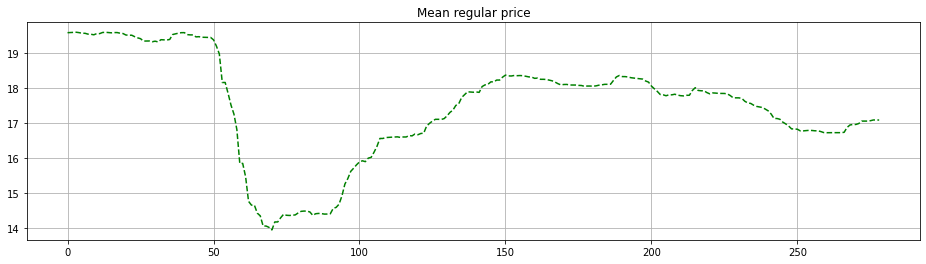

In [22]:
y = df_lin_reg["price"]
X = df_lin_reg["index"]

fig = plt.figure(figsize = (16, 4))
plt.plot(X, y, "g--")
plt.title("Mean regular price")
plt.grid(True)
plt.show()

In [23]:
X = df_lin_reg["index"].to_numpy().reshape(-1, 1)

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("Interception: ", lin_reg.intercept_)
print("Coefficient: ", lin_reg.coef_)

Interception:  17.84895710383976
Coefficient:  [-0.00264209]


In [25]:
y_predict_lin_reg = lin_reg.predict(X)

In [26]:
print("MSE: " + str(mean_squared_error(y, y_predict_lin_reg)))
print("RMSE: " + str(np.sqrt(mean_squared_error(y, y_predict_lin_reg))))

MSE: 2.23287071078147
RMSE: 1.4942793282319975


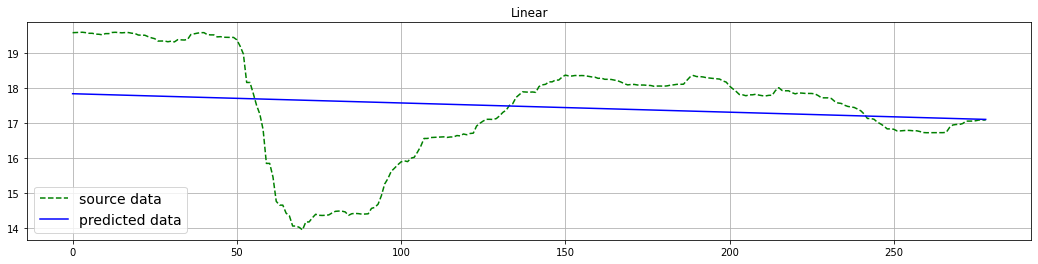

In [27]:
fig = plt.figure(figsize = (18,4))
plt.plot(X, y, "g--", label = "source data")
plt.plot(X, y_predict_lin_reg, "b-", label = "predicted data")
plt.title("Linear")
plt.legend(loc = "lower left", fontsize = 14)
plt.grid(True)
plt.show()

* As we can see in the previous graph, the linear regression model does not really allow us to predict data correctly but it helps us to identify the trend of prices during the last months.

### Elastic Net

* Cost function,

![elastic_net.jpeg](elastic_net.jpeg)

In [28]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

elastic_net = ElasticNet(alpha = 0.01, l1_ratio = 0.5, max_iter = 3000)
poly_feats = PolynomialFeatures(degree = 40, include_bias = False)
std_scaler = StandardScaler()

elastic_net_reg = Pipeline([
    ("poly_features", poly_feats),
    ("std_scaler", std_scaler),
    ("elastic_net", elastic_net)
])

In [29]:
elastic_net_reg.fit(X, y)
y_predicted_elastic_net = elastic_net_reg.predict(X)

In [30]:
print("MSE: " + str(mean_squared_error(y, y_predicted_elastic_net)))
print("RMSE: " + str(np.sqrt(mean_squared_error(y, y_predicted_elastic_net))))

MSE: 1.3110300332977192
RMSE: 1.1450021979444927


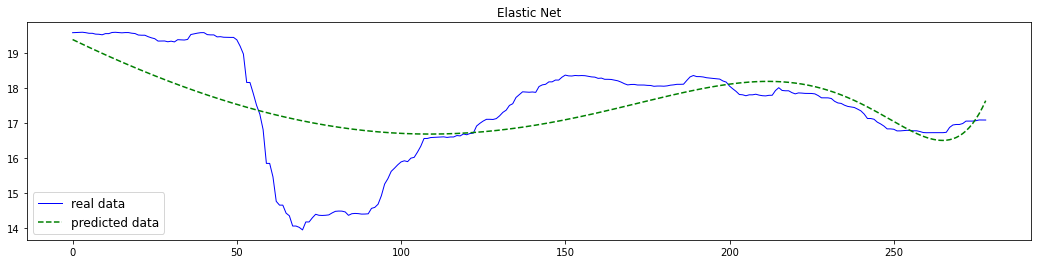

In [31]:
plt.figure(figsize = (18, 4))
plt.plot(X, y, "b-", linewidth = 1, label = "real data")
plt.plot(X, y_predicted_elastic_net, "g--", label = "predicted data")
plt.title("Elastic Net")
plt.legend(loc = "lower left", fontsize = 12)
plt.show()

### Ridge regression

* Cost function,

![ridge_reg.png](ridge_reg.png)

In [32]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha = 0.0001,
              max_iter = 3000,
              tol = -np.infty,
              random_state = 42)

ridge_reg = Pipeline([
    ("poly_features", poly_feats),
    ("std_scaler", std_scaler),
    ("ridge", ridge)
])

ridge_reg.fit(X, y)
y_predicted_ridge = ridge_reg.predict(X)

In [33]:
print("MSE: " + str(mean_squared_error(y, y_predicted_ridge)))
print("RMSE: " + str(np.sqrt(mean_squared_error(y, y_predicted_ridge))))

MSE: 0.37250209918942245
RMSE: 0.6103295005072444


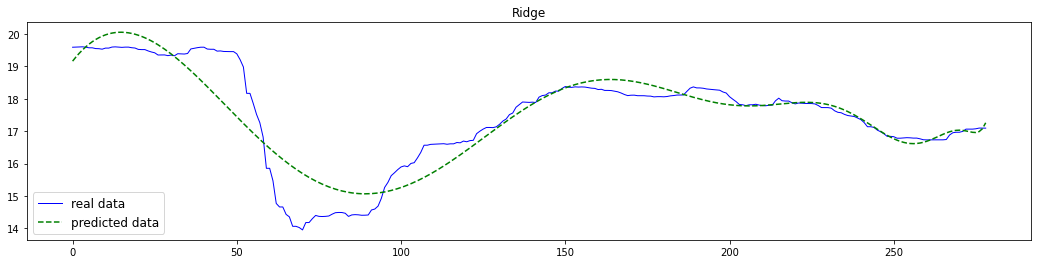

In [34]:
plt.figure(figsize = (18, 4))
plt.plot(X, y, "b-", linewidth = 1, label = "real data")
plt.plot(X, y_predicted_ridge, "g--", label = "predicted data")
plt.title("Ridge")
plt.legend(loc = "lower left", fontsize = 12)
plt.show()

### LASSO (Least Absolute Shrinkage and Selection Operator)

* Cost function,

![Lasso_reg.png](Lasso_reg.png)

In [35]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 10**-3,
              max_iter = 10000,              
              random_state = 42)

lasso_reg = Pipeline([
    ("poly_features", poly_feats),
    ("std_scaler", std_scaler),
    ("lasso", lasso)
])

lasso_reg.fit(X, y)
y_predicted_lasso = lasso_reg.predict(X)

c:\users\migue\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.549182954226296, tolerance: 0.06356043713078612
  model = cd_fast.enet_coordinate_descent(


In [36]:
print("MSE: " + str(mean_squared_error(y, y_predicted_lasso)))
print("RMSE: " + str(np.sqrt(mean_squared_error(y, y_predicted_lasso))))

MSE: 0.8596483422330008
RMSE: 0.92717222900225


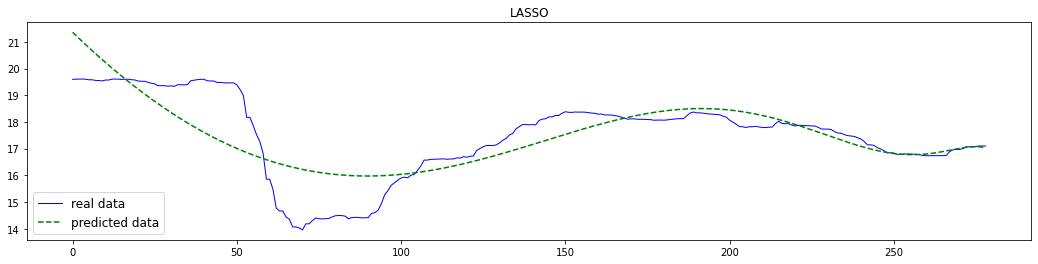

In [37]:
plt.figure(figsize = (18, 4))
plt.plot(X, y, "b-", linewidth = 1, label = "real data")
plt.plot(X, y_predicted_lasso, "g--", label = "predicted data")
plt.title("LASSO")
plt.legend(loc = "lower left", fontsize = 12)
plt.show()

## Conclusion

* From the above we can observe that the model that best fits for the prediction of gasoline prices in the regular product is a Ridge regression, which obtains an MSE: 0.3725 and an RMSE: 0.6103. The above is acceptable considering that during 2020 the standard deviation of prices was 1.6784.


* Although the exercise does not allow us to predict with complete accuracy even the movement of prices in the market, it does allow us to anticipate what the price trend will be in future dates, for example at the end we can see that the Ridge regression advances us an increase prices, this may be a consequence of a cost movement or that the market is trying to push the price up.


* A strategy can be predefined with the previous results in order to maximize the net profits of each site by opting for a volume strategy or a margin strategy.


* The different models are only a brief example of how ML algorithms can be used, leaving aside deep learning algorithms such as LSTM, to anticipate price movements in the market but to make the models much better it is necessary to add variables such as the cost, the price of crude oil, international references and movements in fuel inventories.